<a href="https://colab.research.google.com/github/urieliram/statistical/blob/main/Tarea16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install dtw-python

In [2]:
pip install dtreeviz

In [3]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV, LarsCV, Lasso, Ridge, BayesianRidge, LinearRegression
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
from sklearn.metrics.pairwise import pairwise_distances_argmin
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from math import sqrt
from dtw import *
%matplotlib inline

sns.set_theme(style="white")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
def trunc(values, decs=0):
    return np.trunc(values*10**decs)/(10**decs)

In [5]:
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; NARA='#ff8000'; AZUL='#168fff'; OTROAZUL = "b-"; ROJO= "r-";
def print_serie2(serie_,prototipo_,title_,ytitle_,xtitle_,sizex_=8,sizey_=5,namefile_='figure.png'):
    fig, ax1 = plt.subplots(figsize=(sizex_,sizey_))
    plt.title(title_,fontsize='x-large',color=NARA)
    ax1.set_xlabel(xtitle_, color=NARA, fontsize='large')
    ax1.set_ylabel(ytitle_, color=NARA, fontsize='large')
    plt.tick_params(colors = NARA, which='both')
    ax1.spines['bottom'].set_color(NARA)
    ax1.spines['top'   ].set_color(NARA) 
    ax1.spines['right' ].set_color(NARA)
    ax1.spines['left'  ].set_color(NARA)
    if len(prototipo_) != 0: 
        plt.plot(prototipo_,alpha=0.6, linestyle='dashed', color='red', linewidth=3)
    for p in serie_:
        plt.plot(p,alpha=0.3, linewidth=2)    
    plt.savefig(namefile_, transparent=True)         
    plt.show()

In [6]:
## Preparamos la información para graficar la importancia y las posiciones en Random Forest Regressor
def print_importances(model_,labels_,namefile_):
    i=0
    labels = [str(x) for x in labels_]
    labels_importances = []
    for feature in model_.feature_importances_:
        labels_importances.append((feature,labels[i]))
        i=i+1   
    labels_importances.sort(key=lambda tup: tup[0], reverse=False)
    importances = []
    labels      = []
    for tup in labels_importances:
        importances.append(tup[0])
        labels.append(tup[1])
    fig, ax = plt.subplots()
    y_pos = np.arange(len(importances))
    ax.set_yticks(ticks=y_pos)
    ax.barh(labels, importances, align='center',color=CYAN)
    ax.invert_yaxis()
    ax.set_xlabel('Importancia', color=NARA, fontsize='large')
    ax.set_ylabel('Variable', color=NARA, fontsize='large')
    ax.set_title( 'Importancia de las variables del bosque aleatorio', color=NARA, fontsize='large')    
    plt.tick_params(colors = NARA, which='both')
    ax.spines['bottom'].set_color(NARA)
    ax.spines['top'   ].set_color(NARA) 
    ax.spines['right' ].set_color(NARA)
    ax.spines['left'  ].set_color(NARA)
    plt.savefig(namefile_, transparent=True)   
    plt.show()

In [7]:
def OLSstep(X, Y, X_2, pi_step_=0.001,verbose_=False):
    model   = sm.OLS(Y, X)
    results = model.fit()
    prediction_Y2 = results.predict(X_2)

    ## Ordenamos los valores 'pi' y se selecciona el más grande.
    i = 0
    pvalues = []
    for pi in results.pvalues:
        pvalues.append((i,pi))
        i = i + 1
    pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
    (i, pi) = pvalues[0]  

    while pi > pi:
        X   = sm.add_constant(X)
        X_2 = sm.add_constant(X_2)   
        if verbose_==True:
            print('Retiramos regresor ---> X' + str(i))
        X   = np.delete(arr=X,   obj=i+0, axis=1)
        X_2 = np.delete(arr=X_2, obj=i+0, axis=1)   
        model   = sm.OLS(Y, X)
        results = model.fit()

        ## Ordenamos los valores 'pi' y se selecciona el más grande
        i = 0
        pvalues = []
        for pi in results.pvalues:
            pvalues.append((i,pi))
            i = i + 1
        pvalues.sort(key=lambda tup: tup[1], reverse=True) ## Ordenamos por 'pi'
        (i, pi) = pvalues[0]
        #prediction   = results.predict(X)   ## Ajuste
        prediction_Y2 = results.predict(X_2) ## Pronóstico
    if len(prediction_Y2) == 0:      
        if verbose_==True:
            print('>>> Warning, no variable was significant in the regression.')
        model   = sm.OLS(Y, X)
        results = model.fit()
        prediction_Y2 = results.predict(X_2)
        
    if verbose_==True:
        print(results.summary())
    return prediction_Y2   

In [8]:
def RF(X, Y, X_2,labels_,typedist_,verbose_=False):
    model         = RandomForestRegressor(random_state=42,n_estimators=200)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    if verbose_==True:
        print_importances(model_=model,labels_=labels_,namefile_='fig_importance_'+typedist_+'_'+'RF')
        print('Parámetros utilizados RF')
        print("bootstrap:         {}".format(model.bootstrap))
        print("n_estimators:      {}".format(model.n_estimators))
        print("max_features:      {}".format(model.max_features))
        print("max_depth:         {}".format(model.max_depth))
        print("min_samples_leaf:  {}".format(model.min_samples_leaf))
        print("min_samples_split: {}".format(model.min_samples_split))
    return prediction_Y2   

In [9]:
def AutoRF(X, Y, X_2,labels_,typedist_,verbose_=False):
## https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    #nestlist = []
    #for i in range(10, 320, 50):
    #    nestlist.append(i)
    #param_grid = { 
    #'bootstrap': [True, False],
    #'n_estimators': nestlist,
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #'min_samples_leaf': [1, 2, 4],
    #'min_samples_split': [2, 5, 10],}
    nestlist = []
    for i in range(10, 320, 50):
        nestlist.append(i)
    param_grid = { 
        'bootstrap': [True, False],
        'n_estimators': nestlist,
        'max_features': ['auto', 'sqrt',],
        'max_depth' : [10, 20, None]}

    model = RandomForestRegressor(random_state=42)
    clf   = GridSearchCV(estimator=model, param_grid=param_grid, cv=5).fit(X, Y)
    model         = clf.best_estimator_
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)

    if verbose_==True:
        print_importances(model_=model,labels_=labels_,namefile_='fig_importance_'+typedist_+'_'+'AutoRF')
        print('Parameters used')
        print("bootstrap:         {}".format(model.bootstrap))
        print("n_estimators:      {}".format(model.n_estimators))
        print("max_features:      {}".format(model.max_features))
        print("max_depth:         {}".format(model.max_depth))
        print("min_samples_leaf:  {}".format(model.min_samples_leaf))
        print("min_samples_split: {}".format(model.min_samples_split))
        
    return prediction_Y2   

In [10]:
def Boosting(X, Y, X_2,typedist_,verbose_=False):
    model         = GradientBoostingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 

In [11]:
def Bagging(X, Y, X_2,typedist_,verbose_=False):
    model         = BaggingRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [12]:
def LinearReg(X, Y, X_2,typedist_,verbose_=False):
    model         = LinearRegression()
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [13]:
def AdaBoost(X, Y, X_2,typedist_,verbose_=False):
    model         = AdaBoostRegressor(random_state=42,)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2 

In [14]:
def BayesRidge(X, Y, X_2,typedist_,verbose_=False):
    model         = BayesianRidge(compute_score=True)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2) 
    return prediction_Y2   

In [15]:
def LassoReg(X, Y, X_2,typedist_,verbose_=True):
    model         = Lasso(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2  

In [16]:
def RidgeReg(X, Y, X_2,typedist_,verbose_=False):
    model         = Ridge(alpha=0.1)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [17]:
def PLS(X, Y, X_2,n_components,typedist_,verbose_=False):
    model         = PLSRegression(n_components=n_components)
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2

In [18]:
def PCR(X, Y, X_2,n_components,typedist_,verbose_=False):
## https://scikit-learn.org/stable/auto_examples/cross_decomposition/plot_pcr_vs_pls.html
    model         = make_pipeline(PCA(n_components=n_components), LinearRegression())
    results       = model.fit(X, Y)
    prediction_Y2 = results.predict(X_2)
    return prediction_Y2   

In [82]:
def VotingEnsemble(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    gb  = GradientBoostingRegressor(random_state=42)
    rf  = RandomForestRegressor(random_state=42)
    br  = BaggingRegressor(random_state=42)
    ab  = AdaBoostRegressor(random_state=42)
    gb.fit(X, Y)
    rf.fit(X, Y)
    br.fit(X, Y)
    ab.fit(X, Y)
    voting = VotingRegressor([("gb",gb), ("rf",rf), ("br",br), ("ab",ab)]) #
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    if verbose_ == True:
        predgb  = gb.predict(X_2)
        predrf  = rf.predict(X_2)
        predbr  = br.predict(X_2)  
        predab  = ab.predict(X_2) 
        ## https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.plot.html Markers, Line styles ,Colors
        fig, ax = plt.subplots(figsize=(19,10))
        plt.plot(predgb,  "gd" , label="GradientBoostingRegressor") ## go- rs 
        plt.plot(predrf,  "b^" , label="RandomForestRegressor")
        plt.plot(predbr,  "go-", label="BaggingRegressor")
        plt.plot(predab,  "bD" , label="AdaBoostRegressor")
        plt.plot(prediction_Y2, "r*", ms=10, label="VotingRegressor")
        plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
        plt.ylabel("predicted")
        plt.xlabel("training samples")
        plt.legend(loc="best")
        plt.title("Regressor predictions and their average")
        plt.tick_params(colors = NARA, which='both')
        ax.spines['bottom'].set_color(NARA)
        ax.spines['top'   ].set_color(NARA) 
        ax.spines['right' ].set_color(NARA)
        ax.spines['left'  ].set_color(NARA)
        plt.savefig("fig_Voting", transparent=True) 
        plt.show()
    return prediction_Y2   

In [81]:
def VotingLinear(X, Y, X_2,verbose_=False):  
    ## https://scikit-learn.org/stable/auto_examples/ensemble/plot_voting_regressor.html#sphx-glr-auto-examples-ensemble-plot-voting-regressor-py
    #pl = PLSRegression()
    lr = LinearRegression()
    ri = Ridge(alpha=0.1)
    #la = Lasso(alpha=0.1)    
    #pc = make_pipeline(PCA(n_components=1), LinearRegression())
    #pl.fit(X, Y)
    lr.fit(X, Y)
    ri.fit(X, Y)
    #la.fit(X, Y)
    #pc.fit(X, Y)
    voting = VotingRegressor([("lr",lr), ("ri",ri)]) #,("pc",pc)("la",la),("pl",pl)
    voting.fit(X, Y)
    prediction_Y2 = voting.predict(X_2)    
    if verbose_ == True:
        #predpl = pl.predict(X_2)
        predlr = lr.predict(X_2)
        predri = ri.predict(X_2)
        #predla = la.predict(X_2)
        #predpc = pc.predict(X_2)
        ## https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.plot.html Markers, Line styles ,Colors
        fig, ax = plt.subplots(figsize=(17,9))
        #plt.plot(predpl,  "gd" , label="PLSRegression")
        plt.plot(predlr,  "b^" , label="LinearRegression")
        plt.plot(predri,  "go-", label="Ridge")
        #plt.plot(predla,  "ys" , label="Lasso")
        #plt.plot(predpc,  "ys" , label="PCR")
        plt.plot(prediction_Y2, "r*", ms=10, label="VotingRegressor")
        plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
        plt.ylabel("predicted")
        plt.xlabel("training samples")
        plt.legend(loc="best")
        plt.title("Regressor predictions and their average")
        plt.tick_params(colors = NARA, which='both')
        ax.spines['bottom'].set_color(NARA)
        ax.spines['top'   ].set_color(NARA) 
        ax.spines['right' ].set_color(NARA)
        ax.spines['left'  ].set_color(NARA)
        plt.savefig("fig_Voting", transparent=True) 
        plt.show()
    return prediction_Y2   

In [21]:
#https://drive.google.com/drive/folders/1Gj3XK9kM-lE18uBMe3qrZOGEm8yAI8i9
#https://www.codegrepper.com/code-examples/python/how+to+read+csv+file+from+google+drive+on+google+colab+
path        = 'https://drive.google.com/uc?export=download&id=' 
URL_Demanda = 'https://drive.google.com/file/d/1xcpXDTE7H6EBMLOkic5lq-lzSwiLG2ZS/view?usp=sharing'

df_Demanda  = pd.read_csv(path + URL_Demanda .split('/')[-2], usecols=[0] ) #names=['CLVUNI','TYPE','NODE'], usecols=[1,2,3,4,5,6,], 1,2,3,4,5,6,7,8,9,10,11,12,13,15,
df_Demanda.dropna(inplace=True)
serie = df_Demanda.to_numpy()
serie = StandardScaler().fit_transform(serie)
serie = serie.ravel() ## Con esto quitamos el bracket o corchete en cada uno de los elementos del arreglo

In [22]:
## Calcula distancia euclidiana
def euclidean(neig1, neig2):
	  distance = 0.0
	  for i in range(len(neig1)):
		    distance += (neig1[i] - neig2[i])**2
	  return sqrt(distance)

In [83]:
def analogo_knn(serie,vsele,k=10,tol=0.8,n_components=3,typedist='euclidian',typereg='OLS',verbose=False):    
#    vsele      : Tamanio de la ventana de selección
#    k          : Número de vecinos a buscar k
#    tol        : Tolerancia de tamaño de ventanas para seleccion de vecinos
#    typedist   : medida de distancia, 'dtw' o 'euclidian' o 'pearson'

    t_o = time.time()
    n = len(serie) ## longitud total de la serie

    ## PASO 1: Selección de las ventanas de mayor correlación.

    ## Calculamos la distancia entre todos los vecinos.
    vsele = vsele
    distances = []
    Y = serie[n-vsele:n]           ## últimos datos
    for i in range(n-2*vsele):                              
        if  typedist == 'dtw':     ## dynamic time warping
            dist = dtw(Y, serie[i:i+vsele]).distance  
        elif typedist == 'pearson':
            dist = np.corrcoef(Y,serie[i:i+vsele])[1,0]
        else:
            dist = euclidean(Y,serie[i:i+vsele])
        if dist > 0:
            distances.append((i, dist))
        
    ## Calculamos el vecindario por distancia de menor a mayor y se guardan las posiciones.
    if typedist == 'pearson':
        ## En caso de pearson se ordena al revés, nos interesan los mayor correlación.
        distances.sort(key=lambda tup: tup[1], reverse=True)
    else:
        ## En caso de pearson se ordena al revés, nos interesan los de menor distancia.
        distances.sort(key=lambda tup: tup[1], reverse=False)

    neighbors  = []
    neighbors2 = []
    positions  = []

    ## Calculamos los k vecinos mas cercanos y guardamos las posiciones.
    i = 0
    for pos, dis in distances:
        if i==0:      
            positions.append(pos)   
            neighbors.append(serie[pos:pos+vsele])
            neighbors2.append(serie[pos+vsele:pos+2*vsele])  
        else:
            bandera = True
            for p in positions:
                 ## si ya teniamos una posición en la lista que pase la tolerancia, ya no la guardamos 
                if (abs(pos - p) < tol*vsele):
                    bandera = False
                    i = i - 1
                    break
            if bandera == True:
                ## Guarda nuevo vecino
                positions.append(pos)   
                neighbors.append(serie[pos:pos+vsele])
                neighbors2.append(serie[pos+vsele:pos+2*vsele])  
                bandera = False
        i = i + 1
        if i == k:
            break
    if verbose==True:
        print('positions KNN:', positions) ## posición de los k vecinos mas cercanos

    neighbors  = np.array(neighbors)  
    neighbors2 = np.array(neighbors2)    
    vacia = []
    if verbose==True:
        print_serie2(neighbors,Y,'Selección con KNN:'+typedist,'demanda','time',8,5,'fig_t16_X_'+typedist+'_'+typereg)

    t_sel = time.time() - t_o

    ## PASO 2: Regresión entre los vecinos mas cercanos 'X' y la última ventana 'Y'

    ## Definimos nuestros regresores   
    X   = (neighbors.T).tolist()
    X_2 = (neighbors2.T).tolist()
    Y   = (Y).tolist()
    prediction_Y2 = []

    ## -- Random forest regression --
    if typereg == 'RF':
        prediction_Y2 = RF(X,Y,X_2,labels_=positions,typedist_=typedist,verbose_=verbose)

    ## -- OLS with Stepwise --
    if typereg == 'OLSstep':
        prediction_Y2 = OLSstep(X,Y,X_2, pi_step_=0.001,verbose_=verbose)

    ## -- Gradiant boosting regression --
    if typereg == 'Boosting':
        prediction_Y2 = Boosting(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Bagging regression --
    if typereg == 'Bagging':
        prediction_Y2 = Bagging(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Linear regression --
    if typereg == 'LinearReg':
        prediction_Y2 = LinearReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ada boosting --
    if typereg == 'AdaBoost':
        prediction_Y2 = AdaBoost(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Bayesian Ridge --
    if typereg == 'BayesRidge':
        prediction_Y2 = BayesRidge(X, Y, X_2,typedist_=typedist,verbose_=verbose)  

    ## -- Lasso regression --
    if typereg == 'LassoReg':
        prediction_Y2 = LassoReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)   

    ## -- Ridge regression --
    if typereg == 'RidgeReg':
        prediction_Y2 = RidgeReg(X, Y, X_2,typedist_=typedist,verbose_=verbose)

    ## -- PLS Regression --
    if typereg == 'PLS':
        prediction_Y2 = PLS(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- PCA Regression --
    if typereg == 'PCR':
        prediction_Y2 = PCR(X, Y, X_2,n_components=n_components,typedist_=typedist,verbose_=verbose)

    ## -- Voting regression with ensemble models -- 
    if typereg == 'VotingEnsemble':
        prediction_Y2 = VotingEnsemble(X,Y,X_2,verbose_=verbose)

    ## -- Voting regression with linear model -- 
    if typereg == 'VotingLinear':
        prediction_Y2 = VotingLinear(X,Y,X_2,verbose_=verbose)
        
    ## -- Random forrest regression with GridSearchCV--
    if typereg == 'AutoRF':
        prediction_Y2 = AutoRF(X, Y, X_2,labels_=positions,typedist_=typedist,verbose_=verbose)        

    if verbose==True:
        print_serie2(neighbors2,prediction_Y2, 'Pronóstico - ' + typedist+' - ' + typereg ,'Demanda','Tiempo',8,5,'fig_t15_Y2_'+typedist+'_'+typereg)

    t_reg = time.time() - t_sel - t_o

    return prediction_Y2, t_sel, t_reg

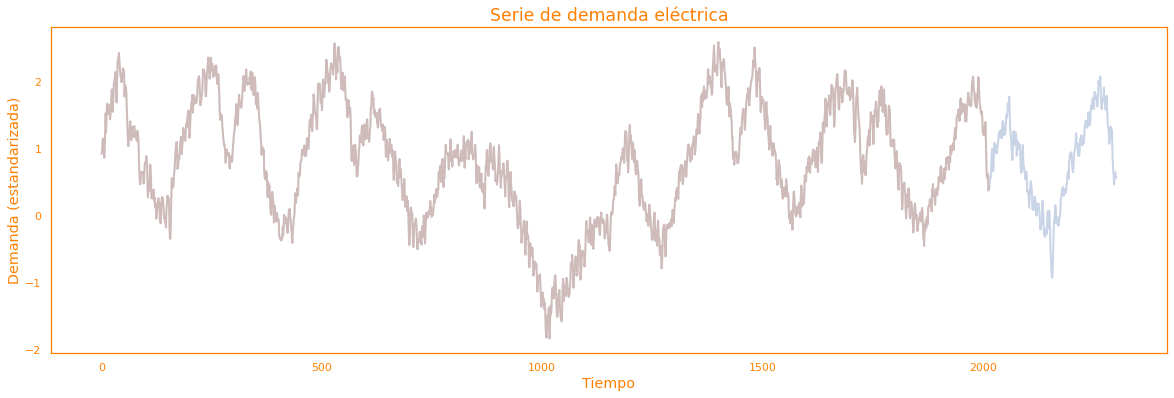

In [84]:
## ... (time serie) ... window.window.window.window.window.window.window.window.window.window.window.
##                                           |                                               |       |
##                                           |                                               |       |
##                                           |<------------------ vsele -------------------->|<vpred>|
##                                                       (selection and regression)        (prediction)
##                                                                                                 
##|<---------------------------------------- train ----------------------------------------->| <test>|

## Parámetros del método Análogo
periods       = 288        ## Número de periodos en una ventana
periods_sele  = 7          ## Número de ventanas de selección
periods_pred  = 1          ## Número de ventanas de pronóstico

vsele = periods * periods_sele ## Número de periodos para selección
vpred = periods * periods_pred ## Número de periodos para pronóstico

k   = 6   ## k:   número de vecinos mas cercanos
tol = 0.8 ## tol: porcentaje de tolerancia de cercania entre ventanas

## Dibujamos la ventana de histórico y los datos de prueba  
series = []; vacia = []; n = 2
series.append(serie[len(serie)-n*vsele : len(serie)-vsele+vpred])
series.append(serie[len(serie)-n*vsele : len(serie)-vsele])
print_serie2(serie_=series,prototipo_=vacia , title_='Serie de demanda eléctrica', ytitle_='Demanda (estandarizada)',xtitle_='Tiempo', sizex_=20, sizey_=6, namefile_='fig_t15_demanda')

## Definimos la ventana de prueba y entrenamiento
X_train = serie[0 : len(serie) - vpred]
y_test  = serie[len(serie) - vpred : len(serie)]

dferror = pd.DataFrame(columns=['distance','regression','MAE','MAPE','timesel','timereg'])

---
## Probamos el modelo con 'pearson' + 'RF'.

In [25]:
if 1==1:
    pred_pea_rf, t_sel_pea_rf, t_reg_pea_rf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='RF',verbose=False)
    mae_pea_rf  = mean_absolute_error(y_test,pred_pea_rf[0:vpred])
    mape_pea_rf = mean_absolute_percentage_error(y_test,pred_pea_rf[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','RF',mae_pea_rf,mape_pea_rf,t_sel_pea_rf,t_reg_pea_rf]

---
## Probamos el modelo con 'pearson' + 'OLSstep'.

In [26]:
if 1==1:
    pred_pea_ols, t_sel_pea_ols, t_reg_pea_ols = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='OLSstep',verbose=False)
    mae_pea_ols  = mean_absolute_error(y_test,pred_pea_ols[0:vpred])    
    mape_pea_ols = mean_absolute_percentage_error(y_test,pred_pea_ols[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','OLSstep',mae_pea_ols,mape_pea_ols,t_sel_pea_ols,t_reg_pea_ols]

---
## Probamos el modelo con 'pearson' + 'Boosting'.

In [27]:
if 1==1:
    pred_pea_bos, t_sel_pea_bos, t_reg_pea_bos = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='Boosting',verbose=False)
    mae_pea_bos  = mean_absolute_error(y_test,pred_pea_bos[0:vpred])    
    mape_pea_bos = mean_absolute_percentage_error(y_test,pred_pea_bos[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','Boosting',mae_pea_bos,mape_pea_bos,t_sel_pea_bos,t_reg_pea_bos]

---
## Probamos el modelo con 'pearson' + 'Bagging'.

In [28]:
if 1==1:
    pred_pea_bag, t_sel_pea_bag, t_reg_pea_bag = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='Bagging',verbose=False)
    mae_pea_bag  = mean_absolute_error(y_test,pred_pea_bag[0:vpred])    
    mape_pea_bag = mean_absolute_percentage_error(y_test,pred_pea_bag[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','Bagging',mae_pea_bag,mape_pea_bag,t_sel_pea_bag,t_reg_pea_bag]

---
## Probamos el modelo con 'pearson' + 'LinearReg'.

In [29]:
if 1==1:
    pred_pea_lin, t_sel_pea_lin, t_reg_pea_lin = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='LinearReg',verbose=False)
    mae_pea_lin  = mean_absolute_error(y_test,pred_pea_lin[0:vpred])    
    mape_pea_lin = mean_absolute_percentage_error(y_test,pred_pea_lin[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','LinearReg',mae_pea_lin,mape_pea_lin,t_sel_pea_lin,t_reg_pea_lin]

---
## Probamos el modelo con 'pearson' + 'AdaBoost'.

In [30]:
if 1==1:
    pred_pea_ada, t_sel_pea_ada, t_reg_pea_ada = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='AdaBoost',verbose=False)
    mae_pea_ada  = mean_absolute_error(y_test,pred_pea_ada[0:vpred])    
    mape_pea_ada = mean_absolute_percentage_error(y_test,pred_pea_ada[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','AdaBoost',mae_pea_ada,mape_pea_ada,t_sel_pea_ada,t_reg_pea_ada]

---
## Probamos el modelo con 'pearson' + 'BayesRidge'.

In [31]:
if 1==1:
    pred_pea_bay, t_sel_pea_bay, t_reg_pea_bay = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='BayesRidge',verbose=False)
    mae_pea_bay  = mean_absolute_error(y_test,pred_pea_bay[0:vpred])    
    mape_pea_bay = mean_absolute_percentage_error(y_test,pred_pea_bay[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','BayesRidge',mae_pea_bay,mape_pea_bay,t_sel_pea_bay,t_reg_pea_bay]

---
## Probamos el modelo con 'pearson' + 'LassoReg'.

In [32]:
if 1==1:
    pred_pea_las, t_sel_pea_las, t_reg_pea_las = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='LassoReg',verbose=False)
    mae_pea_las  = mean_absolute_error(y_test,pred_pea_las[0:vpred])    
    mape_pea_las = mean_absolute_percentage_error(y_test,pred_pea_las[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','LassoReg',mae_pea_las,mape_pea_las,t_sel_pea_las,t_reg_pea_las]

---
## Probamos el modelo con 'pearson' + 'RidgeReg'.

In [33]:
if 1==1:
    pred_pea_rid, t_sel_pea_rid, t_reg_pea_rid = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='RidgeReg',verbose=False)
    mae_pea_rid  = mean_absolute_error(y_test,pred_pea_rid[0:vpred])    
    mape_pea_rid = mean_absolute_percentage_error(y_test,pred_pea_rid[0:vpred])    
    dferror.loc[dferror.shape[0]] = ['pearson','RidgeReg',mae_pea_rid,mape_pea_rid,t_sel_pea_rid,t_reg_pea_rid]

---
## Probamos el modelo con 'pearson' + 'PLS'.

In [ ]:
if 1==1:
    pred_pea_pls, t_sel_pea_pls, t_reg_pea_pls = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,n_components=1,typedist='pearson',typereg='PLS',verbose=True)
    mae_pea_pls  = mean_absolute_error(y_test,pred_pea_pls[0:vpred])    
    mape_pea_pls = mean_absolute_percentage_error(y_test,pred_pea_pls[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','PLS',mae_pea_pls,mape_pea_pls,t_sel_pea_pls,t_reg_pea_pls]

---
## Probamos el modelo con 'pearson' + 'PCR'.

In [ ]:
if 1==1:
    pred_pea_pcr, t_sel_pea_pcr, t_reg_pea_pcr = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,n_components=2,typedist='pearson',typereg='PCR',verbose=True)
    mae_pea_pcr  = mean_absolute_error(y_test,pred_pea_pcr[0:vpred])    
    mape_pea_pcr = mean_absolute_percentage_error(y_test,pred_pea_pcr[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','PCR',mae_pea_pcr,mape_pea_pcr,t_sel_pea_pcr,t_reg_pea_pcr]

---
## Probamos el modelo con 'pearson' + 'VotingEnsemble'.

positions KNN: [20164, 22176, 18147, 8069, 14115, 10084]


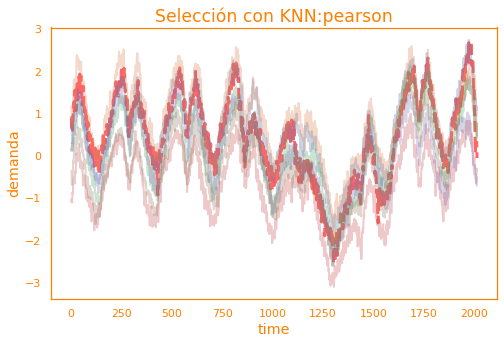

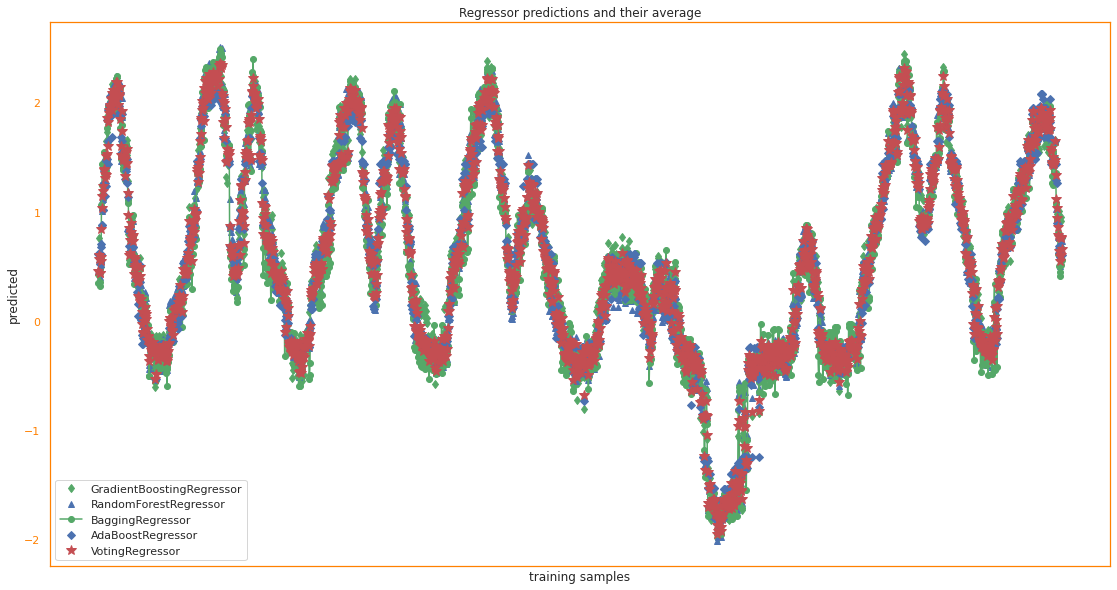

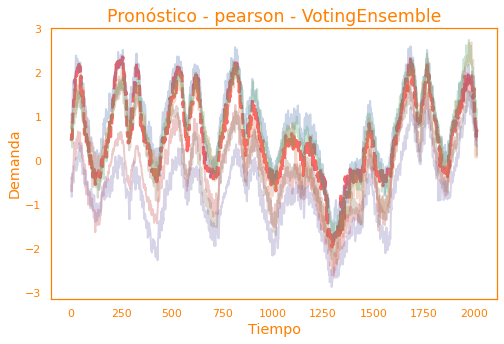

In [85]:
if 1==1:
    pred_pea_vote, t_sel_pea_vote, t_reg_pea_vote = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='VotingEnsemble',verbose=True)
    mae_pea_vote = mean_absolute_error(y_test,pred_pea_vote[0:vpred])
    mape_pea_vote = mean_absolute_percentage_error(y_test,pred_pea_vote[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','VotingEnsemble',mae_pea_vote,mape_pea_vote,t_sel_pea_vote,t_reg_pea_vote]

---
## Probamos el modelo con 'pearson' + 'VotingLinear'.

positions KNN: [20164, 22176, 18147, 8069, 14115, 10084]


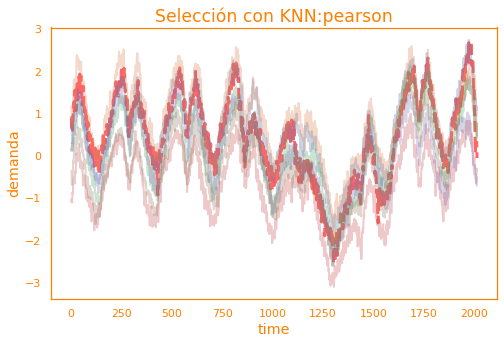

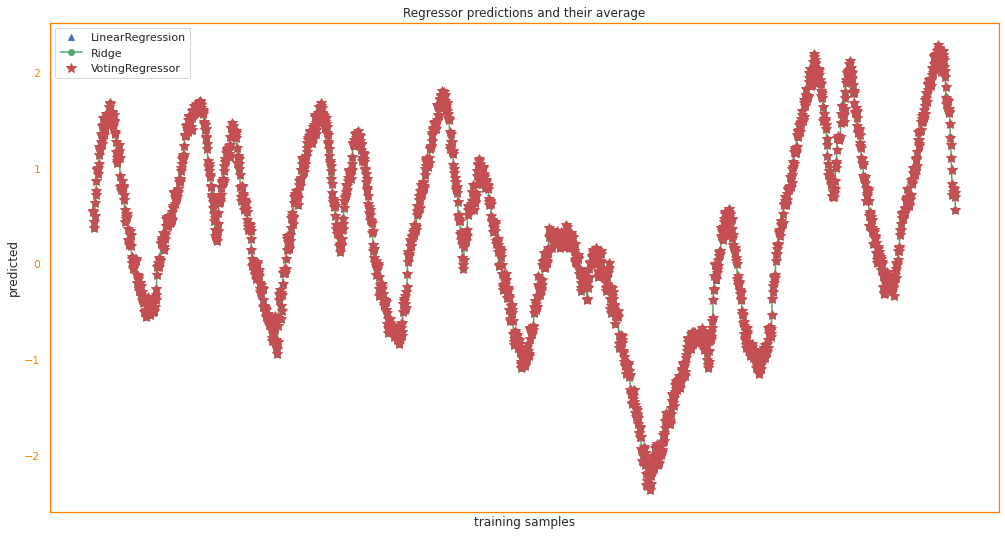

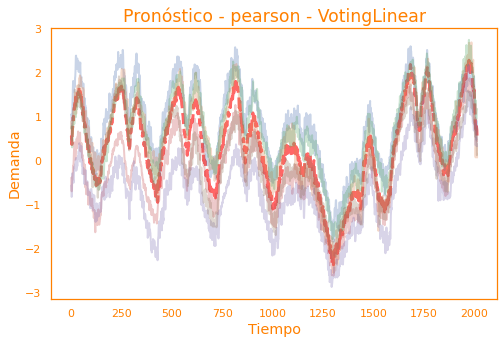

In [86]:
if 1==1:
    pred_pea_votl, t_sel_pea_votl, t_reg_pea_votl = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='VotingLinear',verbose=True)
    mae_pea_votl   = mean_absolute_error(y_test,pred_pea_votl[0:vpred])
    mape_pea_votl = mean_absolute_percentage_error(y_test,pred_pea_votl[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','VotingLinear',mae_pea_votl,mape_pea_votl,t_sel_pea_votl,t_reg_pea_votl]

---

## Probamos el modelo con 'pearson' + 'AutoRF'.



In [37]:
if 1==1:
    pred_pea_arf, t_sel_pea_arf, t_reg_pea_arf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='pearson',typereg='AutoRF',verbose=False)
    mae_pea_arf  = mean_absolute_error(y_test,pred_pea_arf[0:vpred])
    mape_pea_arf = mean_absolute_percentage_error(y_test,pred_pea_arf[0:vpred])
    dferror.loc[dferror.shape[0]] = ['pearson','AutoRF',mae_pea_arf,mape_pea_arf,t_sel_pea_arf,t_reg_pea_arf]

---
# ------------------------ Ahora calcularemos el KNN con distancia euclidiana  ------------------------
---
## Probamos el modelo con 'euclidian' + 'RF'.

In [38]:
if 1==0:
    pred_euc_rf, t_sel_euc_rf, t_reg_euc_rf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='RF',verbose=False)
    mae_euc_rf  = mean_absolute_error(y_test,pred_euc_rf[0:vpred])
    mape_euc_rf = mean_absolute_percentage_error(y_test,pred_euc_rf[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','RF',mae_euc_rf,mape_euc_rf,t_sel_euc_rf,t_reg_euc_rf]

---
## Probamos el modelo con 'euclidian' + 'OLSstep'.

In [39]:
if 1==0:
    pred_euc_ols, t_sel_euc_ols, t_reg_euc_ols = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='OLSstep',verbose=False)
    mae_euc_ols  = mean_absolute_error(y_test,pred_euc_ols[0:vpred])
    mape_euc_ols = mean_absolute_percentage_error(y_test,pred_euc_ols[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','OLSstep',mae_euc_ols,mape_euc_ols,t_sel_euc_ols,t_reg_euc_ols]

---
## Probamos el modelo con 'euclidian' + 'Bosting'.

In [40]:
if 1==0:
    pred_euc_bos, t_sel_euc_bos, t_reg_euc_bos = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='Boosting',verbose=False)
    mae_euc_bos  = mean_absolute_error(y_test,pred_euc_bos[0:vpred])    
    mape_euc_bos = mean_absolute_percentage_error(y_test,pred_euc_bos[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','Boosting',mae_euc_bos,mape_euc_bos,t_sel_euc_bos,t_reg_euc_bos]

---
## Probamos el modelo con 'euclidian' + 'Bagging'.

In [41]:
if 1==0:
    pred_euc_bag, t_sel_euc_bag, t_reg_euc_bag = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='Bagging',verbose=False)
    mae_euc_bag  = mean_absolute_error(y_test,pred_euc_bag[0:vpred])    
    mape_euc_bag = mean_absolute_percentage_error(y_test,pred_euc_bag[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','Bagging',mae_euc_bag,mape_euc_bag,t_sel_euc_bag,t_reg_euc_bag]

---
## Probamos el modelo con 'euclidian' + 'LinearReg'.

In [42]:
if 1==0:
    pred_euc_lin, t_sel_euc_lin, t_reg_euc_lin = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='LinearReg',verbose=False)
    mae_euc_lin  = mean_absolute_error(y_test,pred_euc_lin[0:vpred])    
    mape_euc_lin = mean_absolute_percentage_error(y_test,pred_euc_lin[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','LinearReg',mae_euc_lin,mape_euc_lin,t_sel_euc_lin,t_reg_euc_lin]

---
## Probamos el modelo con 'euclidian' + 'AdaBoost'.

In [43]:
if 1==0:
    pred_euc_ada, t_sel_euc_ada, t_reg_euc_ada = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='AdaBoost',verbose=False)
    mae_euc_ada  = mean_absolute_error(y_test,pred_euc_ada[0:vpred])    
    mape_euc_ada = mean_absolute_percentage_error(y_test,pred_euc_ada[0:vpred])    
    dferror.loc[dferror.shape[0]] = ['euclidian','AdaBoost',mae_euc_ada,mape_euc_ada,t_sel_euc_ada,t_reg_euc_ada]

---
## Probamos el modelo con 'euclidian' + 'BayesRidge'.

In [44]:
if 1==0:
    pred_euc_bay, t_sel_euc_bay, t_reg_euc_bay = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='BayesRidge',verbose=False)
    mae_euc_bay  = mean_absolute_error(y_test,pred_euc_bay[0:vpred])    
    mape_euc_bay = mean_absolute_percentage_error(y_test,pred_euc_bay[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','BayesRidge',mae_euc_bay,mape_euc_bay,t_sel_euc_bay,t_reg_euc_bay]

---
## Probamos el modelo con 'euclidian' + 'LassoReg'.

In [45]:
if 1==0:
    pred_euc_las, t_sel_euc_las, t_reg_euc_las = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='LassoReg',verbose=False)
    mae_euc_las  = mean_absolute_error(y_test,pred_euc_las[0:vpred])    
    mape_euc_las = mean_absolute_percentage_error(y_test,pred_euc_las[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','LassoReg',mae_euc_las,mape_euc_las,t_sel_euc_las,t_reg_euc_las]

---
## Probamos el modelo con 'euclidian' + 'RidgeReg'.

In [46]:
if 1==0:
    pred_euc_rid, t_sel_euc_rid, t_reg_euc_rid = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='RidgeReg',verbose=False)
    mae_euc_rid  = mean_absolute_error(y_test,pred_euc_rid[0:vpred])    
    mape_euc_rid = mean_absolute_percentage_error(y_test,pred_euc_rid[0:vpred])    
    dferror.loc[dferror.shape[0]] = ['euclidian','RidgeReg',mae_euc_rid,mape_euc_rid,t_sel_euc_rid,t_reg_euc_rid]

---
## Probamos el modelo con 'euclidian' + 'PLS'.

In [47]:
if 1==0:
    pred_euc_pls, t_sel_euc_pls, t_reg_euc_pls = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,n_components=4,typedist='euclidian',typereg='PLS',verbose=False)
    mae_euc_pls  = mean_absolute_error(y_test,pred_euc_pls[0:vpred])    
    mape_euc_pls = mean_absolute_percentage_error(y_test,pred_euc_pls[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','PLS',mae_euc_pls,mape_euc_pls,t_sel_euc_pls,t_reg_euc_pls]

---
## Probamos el modelo con 'euclidian' + 'PCR'.

In [48]:
if 1==0:
    pred_euc_pcr, t_sel_euc_pcr, t_reg_euc_pcr = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,n_components=5,typedist='euclidian',typereg='PCR',verbose=False)
    mae_euc_pcr  = mean_absolute_error(y_test,pred_euc_pcr[0:vpred])    
    mape_euc_pcr = mean_absolute_percentage_error(y_test,pred_euc_pcr[0:vpred])    
    dferror.loc[dferror.shape[0]] = ['euclidian','PCR',mae_euc_pcr,mape_euc_pcr,t_sel_euc_pcr,t_reg_euc_pcr]

---
## Probamos el modelo con 'euclidian' + 'Voting'.

In [49]:
if 1==0:
    pred_euc_vot, t_sel_euc_vot, t_reg_euc_vot = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='Voting',verbose=True)
    mae_euc_vot  = mean_absolute_error(y_test,pred_euc_vot[0:vpred])
    mape_euc_vot = mean_absolute_percentage_error(y_test,pred_euc_vot[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','Voting',mae_euc_vot,mape_euc_vot,t_sel_euc_vot,t_reg_euc_vot]

---

## Probamos el modelo con 'euclidian' + 'AutoRF'.

In [50]:
if 1==0:
    pred_euc_arf, t_sel_euc_arf, t_reg_euc_arf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='euclidian',typereg='AutoRF',verbose=False)
    mae_euc_arf  = mean_absolute_error(y_test,pred_euc_arf[0:vpred])
    mape_euc_arf = mean_absolute_percentage_error(y_test,pred_euc_arf[0:vpred])
    dferror.loc[dferror.shape[0]] = ['euclidian','AutoRF',mae_euc_arf,mape_euc_arf,t_sel_euc_arf,t_reg_euc_arf]

---
# -------------------- Ahora calcularemos el KNN con dynamic time warping  ------------------------
---
## Probamos el modelo con 'dtw' + 'OLS'.

In [51]:
if 1==0:
    pred_dtw_ols, t_sel_dtw_ols, t_reg_dtw_ols = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='dtw',typereg='OLSstep',verbose=False)
    mae_dtw_ols  = mean_absolute_error(y_test,pred_dtw_ols[0:vpred])
    mape_dtw_ols = mean_absolute_percentage_error(y_test,pred_dtw_ols[0:vpred])
    dferror.loc[dferror.shape[0]] = ['dtw','OLSstep',mae_dtw_ols,mape_dtw_ols,t_sel_dtw_ols,t_reg_dtw_ols]

---
## Probamos el modelo con 'dtw' + 'RF'.

In [52]:
if 1==0:
    pred_dtw_rf, t_sel_dtw_rf, t_reg_dtw_rf = analogo_knn(X_train,vsele=vsele,k=k,tol=tol,typedist='dtw',typereg='RF',verbose=False)
    mae_dtw_rf  = mean_absolute_error(y_test,pred_dtw_rf[0:vpred])
    mape_dtw_rf = mean_absolute_percentage_error(y_test,pred_dtw_rf[0:vpred]) 
    dferror.loc[dferror.shape[0]] = ['dtw','RF',mae_dtw_rf,mape_dtw_rf,t_sel_dtw_rf,t_reg_dtw_rf]

---
## Comparamos graficamente los resultados

In [53]:
print('| SELECCIÓN      | REGRESIÓN      | MAE             | MAPE             | TIEMPO SELECCIÓN     | TIEMPO REGRESIÓN  |')
print('| :------------- | :------------- | -------------:  | -------------:   |-------------:        |-------------:     |')
print('| PEARSON        | RF             |',str(trunc(mae_pea_rf,4)),'         |',str(trunc(mape_pea_rf,4)),'         |',str(trunc(t_sel_pea_rf,4)),'              |   ',str(trunc(t_reg_pea_rf,4)),     '        |')
print('| PEARSON        | OLS + STEP     |',str(trunc(mae_pea_ols,4)),'         |',str(trunc(mape_pea_ols,4)),'         |',str(trunc(t_sel_pea_ols,4)),'              |   ',str(trunc(t_reg_pea_ols,4)), '        |')
print('| PEARSON        | Boosting       |',str(trunc(mae_pea_bos,4)),'         |',str(trunc(mape_pea_bos,4)),'         |',str(trunc(t_sel_pea_bos,4)),'              |   ',str(trunc(t_reg_pea_bos,4)), '        |')
print('| PEARSON        | Bagging        |',str(trunc(mae_pea_bag,4)),'         |',str(trunc(mape_pea_bag,4)),'         |',str(trunc(t_sel_pea_bag,4)),'              |   ',str(trunc(t_reg_pea_bag,4)), '        |')
print('| PEARSON        | OLS            |',str(trunc(mae_pea_lin,4)),'         |',str(trunc(mape_pea_lin,4)),'         |',str(trunc(t_sel_pea_lin,4)),'              |   ',str(trunc(t_reg_pea_lin,4)), '        |')
print('| PEARSON        | AdaBoost       |',str(trunc(mae_pea_ada,4)),'         |',str(trunc(mape_pea_ada,4)),'         |',str(trunc(t_sel_pea_ada,4)),'              |   ',str(trunc(t_reg_pea_ada,4)), '        |')
print('| PEARSON        | BayesRidge     |',str(trunc(mae_pea_bay,4)),'         |',str(trunc(mape_pea_bay,4)),'         |',str(trunc(t_sel_pea_bay,4)),'              |   ',str(trunc(t_reg_pea_bay,4)), '        |')
print('| PEARSON        | Lasso          |',str(trunc(mae_pea_las,4)),'         |',str(trunc(mape_pea_las,4)),'         |',str(trunc(t_sel_pea_las,4)),'              |   ',str(trunc(t_reg_pea_las,4)), '        |')
print('| PEARSON        | Ridge          |',str(trunc(mae_pea_rid,4)),'         |',str(trunc(mape_pea_rid,4)),'         |',str(trunc(t_sel_pea_rid,4)),'              |   ',str(trunc(t_reg_pea_rid,4)), '        |')
print('| PEARSON        | PLS            |',str(trunc(mae_pea_pls,4)),'         |',str(trunc(mape_pea_pls,4)),'         |',str(trunc(t_sel_pea_pls,4)),'              |   ',str(trunc(t_reg_pea_pls,4)), '        |')
print('| PEARSON        | PCR            |',str(trunc(mae_pea_pcr,4)),'         |',str(trunc(mape_pea_pcr,4)),'         |',str(trunc(t_sel_pea_pcr,4)),'              |   ',str(trunc(t_reg_pea_pcr,4)), '        |')
print('| PEARSON        | Voting         |',str(trunc(mae_pea_vot,4)),'         |',str(trunc(mape_pea_vot,4)),'         |',str(trunc(t_sel_pea_vot,4)),'              |   ',str(trunc(t_reg_pea_vot,4)), '        |')
print('| PEARSON        | AutoRF         |',str(trunc(mae_pea_arf,4)),'         |',str(trunc(mape_pea_arf,4)),'         |',str(trunc(t_sel_pea_arf,4)),'              |   ',str(trunc(t_reg_pea_arf,4)), '      |')

#print('| EUCLIDIAN      | RF             |',str(trunc(mae_euc_rf,4)),'         |',str(trunc(mape_euc_rf,4)),'         |',str(trunc(t_sel_euc_rf,4)),'             |   ',str(trunc(t_reg_euc_rf,4)),     '        |')
#print('| EUCLIDIAN      | OLS + STEP     |',str(trunc(mae_euc_ols,4)),'         |',str(trunc(mape_euc_ols,4)),'         |',str(trunc(t_sel_euc_ols,4)),'             |   ',str(trunc(t_reg_euc_ols,4)),  '        |')
#print('| EUCLIDIAN      | Boosting       |',str(trunc(mae_euc_bos,4)),'         |',str(trunc(mape_euc_bos,4)),'         |',str(trunc(t_sel_euc_bos,4)),'              |   ',str(trunc(t_reg_euc_bos,4)), '        |')
#print('| EUCLIDIAN      | Bagging        |',str(trunc(mae_euc_bag,4)),'         |',str(trunc(mape_euc_bag,4)),'         |',str(trunc(t_sel_euc_bag,4)),'              |   ',str(trunc(t_reg_euc_bag,4)), '        |')
#print('| EUCLIDIAN      | OLS            |',str(trunc(mae_euc_lin,4)),'         |',str(trunc(mape_euc_lin,4)),'         |',str(trunc(t_sel_euc_lin,4)),'              |   ',str(trunc(t_reg_euc_lin,4)), '        |')
#print('| EUCLIDIAN      | AdaBoost       |',str(trunc(mae_euc_ada,4)),'         |',str(trunc(mape_euc_ada,4)),'         |',str(trunc(t_sel_euc_ada,4)),'              |   ',str(trunc(t_reg_euc_ada,4)), '        |')
#print('| EUCLIDIAN      | BayesRidge     |',str(trunc(mae_euc_bay,4)),'         |',str(trunc(mape_euc_bay,4)),'         |',str(trunc(t_sel_euc_bay,4)),'              |   ',str(trunc(t_reg_euc_bay,4)), '        |')
#print('| EUCLIDIAN      | Lasso          |',str(trunc(mae_euc_las,4)),'         |',str(trunc(mape_euc_las,4)),'         |',str(trunc(t_sel_euc_las,4)),'              |   ',str(trunc(t_reg_euc_las,4)), '        |')
#print('| EUCLIDIAN      | Ridge          |',str(trunc(mae_euc_rid,4)),'         |',str(trunc(mape_euc_rid,4)),'         |',str(trunc(t_sel_euc_rid,4)),'              |   ',str(trunc(t_reg_euc_rid,4)), '        |')
#print('| EUCLIDIAN      | PLS            |',str(trunc(mae_euc_pls,4)),'         |',str(trunc(mape_euc_pls,4)),'         |',str(trunc(t_sel_euc_pls,4)),'              |   ',str(trunc(t_reg_euc_pls,4)), '        |')
#print('| EUCLIDIAN      | PCR            |',str(trunc(mae_euc_pcr,4)),'         |',str(trunc(mape_euc_pcr,4)),'         |',str(trunc(t_sel_euc_pcr,4)),'              |   ',str(trunc(t_reg_euc_pcr,4)), '        |')
#print('| EUCLIDIAN      | Voting         |',str(trunc(mae_euc_vot,4)),'         |',str(trunc(mape_euc_vot,4)),'          |',str(trunc(t_sel_euc_vot,4)),'             |   ',str(trunc(t_reg_euc_vot,4)), '        |')
#print('| EUCLIDIAN      | AutoRF         |',str(trunc(mae_euc_arf,4)),'         |',str(trunc(mape_euc_arf,4)),'         |',str(trunc(t_sel_euc_arf,4)),'             |   ',str(trunc(t_reg_euc_arf,4)),  '      |')

#print('| DTW            | OLS + STEP     |',str(trunc(mae_dtw_ols,4)),'         |',str(trunc(mape_dtw_ols,4)),'         |',str(trunc(t_sel_dtw_ols,4)),'            |   ',str(trunc(t_reg_dtw_ols,4)),    '|')
#print('| DTW            | RF             |',str(trunc(mae_dtw_rf,4)),'         |',str(trunc(mape_dtw_rf,4)),'          |',str(trunc(t_sel_dtw_rf,4)),'            |   ',str(trunc(t_reg_dtw_rf,4)),    '|')

| SELECCIÓN      | REGRESIÓN      | MAE             | MAPE             | TIEMPO SELECCIÓN     | TIEMPO REGRESIÓN  |
| :------------- | :------------- | -------------:  | -------------:   |-------------:        |-------------:     |
| PEARSON        | RF             | 0.4556          | 18.7231          | 4.6258               |    3.8404         |
| PEARSON        | OLS + STEP     | 0.2346          | 36.1821          | 6.1008               |    0.0201         |
| PEARSON        | Boosting       | 0.4459          | 16.5175          | 6.229               |    0.8247         |
| PEARSON        | Bagging        | 0.4502          | 34.1345          | 5.6608               |    0.1789         |
| PEARSON        | OLS            | 0.2326          | 34.1343          | 5.988               |    0.0276         |
| PEARSON        | AdaBoost       | 0.4105          | 23.2605          | 6.0604               |    0.3142         |
| PEARSON        | BayesRidge     | 0.2329          | 34.0965          | 4

In [54]:
dferror["time"]    = dferror["timereg"] + dferror["timesel"]
dferror["invtime"] = 1 / ( dferror["timereg"] + dferror["timesel"])
dferror["invtime/MAPE"] = dferror["invtime"] / dferror["MAPE"]
dferror["invtime/MAE"]  = dferror["invtime"] / dferror["MAE"]
dferror.sort_values("invtime/MAE",ascending=False)
dferror.sort_values("invtime/MAPE",ascending=False)

,distance,regression,MAE,MAPE,timesel,timereg,time,invtime,invtime/MAPE,invtime/MAE
8,pearson,RidgeReg,0.232625,34.132797,2.445537,0.009547,2.455085,0.407318,0.011933,1.750967
9,pearson,PLS,0.294741,27.571510,2.943085,0.535871,3.478956,0.287443,0.010425,0.975238
7,pearson,LassoReg,0.217714,25.839481,4.282408,0.010860,4.293268,0.232923,0.009014,1.069857
2,pearson,Boosting,0.445984,16.517568,6.229086,0.824772,7.053859,0.141766,0.008583,0.317873
10,pearson,PCR,0.235455,35.352837,2.953459,0.551185,3.504644,0.285336,0.008071,1.211848
5,pearson,AdaBoost,0.410534,23.260583,6.060464,0.314268,6.374733,0.156869,0.006744,0.382110
0,pearson,RF,0.455674,18.723194,4.625825,3.840470,8.466295,0.118115,0.006309,0.259210
6,pearson,BayesRidge,0.232954,34.096537,4.872025,0.033525,4.905550,0.203851,0.005979,0.875070
11,pearson,Voting,0.392788,25.865048,2.917905,4.637048,7.554953,0.132364,0.005117,0.336984
3,pearson,Bagging,0.450229,34.134505,5.660848,0.178933,5.839781,0.171239,0.005017,0.380338


No handles with labels found to put in legend.


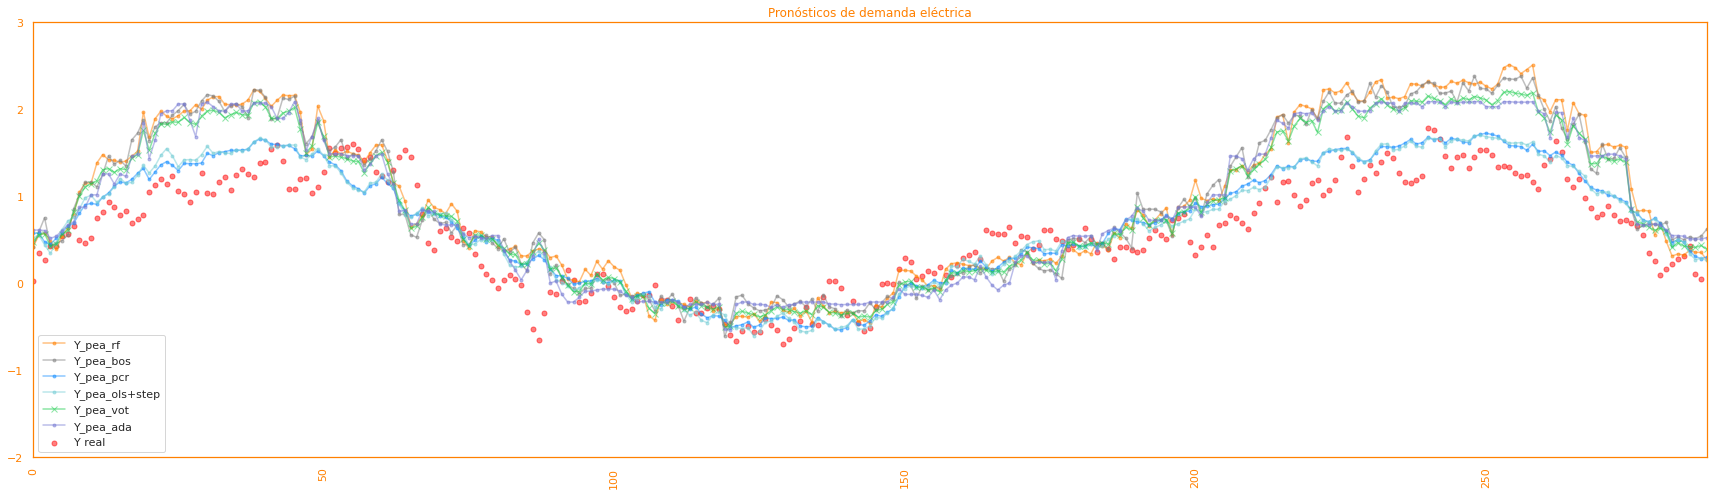

In [55]:
fig  = plt.figure(figsize=(30,8))
axes = fig.add_subplot(1, 1, 1)
axes.legend()
CYAN = '#76ced6' ; LILA = '#777bd4'; VERDE='#17cb49'; LETRASNARA ='#ff8000'; NARA ='#ff8000'; AZUL='#168fff'; GRIS = '#808080'
mytitle = plt.title('Pronósticos de demanda eléctrica') # get the title property handler #plt.getp(title_obj)
plt.setp(mytitle,    color=LETRASNARA) #set the color of title to red
axes.xaxis.label.set_color(LETRASNARA)
axes.yaxis.label.set_color(LETRASNARA)
axes.tick_params(colors=LETRASNARA, which='both')

AUX = np.arange( len(y_test) )
plt.scatter ( AUX, y_test, s=25,marker='o', color = 'red', label = 'Y real', alpha=1/2)
#axes.plot   ( y_test ,     '.-', color = 'red', label = 'Y',         alpha=1/4)
#axes.plot   ( pred_euc_ols, '.-', color = GRIS , label = 'Y_euc_ols', alpha=1/2)
axes.plot   ( pred_pea_rf, '.-',  color = NARA , label = 'Y_pea_rf', alpha=1/2)
axes.plot   ( pred_pea_bos, '.-', color = GRIS , label = 'Y_pea_bos', alpha=1/2)
axes.plot   ( pred_pea_pcr, '.-', color = AZUL , label = 'Y_pea_pcr', alpha=1/2)
axes.plot   ( pred_pea_ols, '.-', color = CYAN , label = 'Y_pea_ols+step', alpha=1/2)
axes.plot   ( pred_pea_vot, '.-', color = VERDE , marker='x', label = 'Y_pea_vot', alpha=1/2)
axes.plot   ( pred_pea_ada, '.-', color = LILA , label = 'Y_pea_ada', alpha=1/2)
#axes.plot  ( pred_euc_rf,  '.-', color = NARA , marker='x', label = 'Y_euc_rf', alpha=1/2)
#axes.plot  ( pred_pea_rf,  '.-', color = GRIS , marker='x', label = 'Y_pea_rf' , alpha=1/2)
#axes.plot   ( pred_pea_arf, '.-', color = VERDE, label = 'Y_pea_arf' , alpha=1/2)
#axes.plot   ( pred_euc_arf, '.-', color = LILA , label = 'Y_euc_arf' , alpha=1/2)
#axes.plot  ( pred_dtw_rf,  '.-', color = AZUL , label = 'Y_dtw_rf', alpha=1/2)
#axes.plot  ( pred_pea_arf, '.-', color = AZUL , label = 'Y_pea_arf' , alpha=1/2)
#axes.plot   ( pred_pea_vot, '.-', color = AZUL , marker='x', label = 'Y_pea_vot', alpha=1/2)
#axes.plot   ( pred_euc_vot, '.-', color = CYAN , marker='x', label = 'Y_euc_vot', alpha=1/2)
#axes.plot  ( xspline[3], yspline[3] , '.-'  , color = VERDE   , label = 'orden=4'  ,alpha=1/2)
#plt.scatter( dfx_miss, dfy_miss, marker='x',  s=170 ,  color = 'red' , label = 'perdidos' ,alpha=1)
marker='x',
plt.axis([0,  288, -2, 3])

axes.spines['bottom'].set_color(LETRASNARA)
axes.spines['top'   ].set_color(LETRASNARA) 
axes.spines['right' ].set_color(LETRASNARA)
axes.spines['left'  ].set_color(LETRASNARA)
plt.legend()  
plt.xticks(rotation=90)
plt.savefig('fig_t15_ajuste_prono.png', transparent=True)
plt.show()

### Ligas interesantes

[sklearn.ensemble: Ensemble Methods](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.ensemble)

[Ensemble methods sklearn](https://scikit-learn.org/0.16/modules/ensemble.html)

[Growing and Pruning Ensembles in Python](https://machinelearningmastery.com/growing-and-pruning-ensembles-in-python/)

[sklearn.feature_selection.RFE](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html#sklearn.feature_selection.RFE)

[link texHow to Develop a Random Forest Ensemble in Python](https://machinelearningmastery.com/random-forest-ensemble-in-python/)